In [23]:
%load_ext lab_black

In [47]:
# set up and dependencies
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [27]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/davidvance/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
pd.set_option('display.max_rows', None)

path = "files/headlines.csv"

In [4]:
df = pd.read_csv(path)

## some light EDA

In [5]:
df.head(10)

,abstract,document_type,headline,keywords,lead_paragraph,news_desk,pub_date,section_name,snippet,type_of_material,word_count
0,Farhad Manjoo picks four products from 2014 th...,article,"Standouts in Tech: Drones, Virtual Reality, In...","[{'name': 'organizations', 'value': 'Oculus VR...",LOTS of cool new technology products come out ...,Business,2015-01-01,Technology,Farhad Manjoo picks four products from 2014 th...,News,824
1,Representative Steve Scalise’s effort to expla...,article,Much of David Duke’s ’91 Campaign Is Now in Lo...,"[{'name': 'persons', 'value': 'Alford, Jeremy'...","BATON ROUGE, La. — David Duke seems a figure f...",National,2015-01-01,U.S.,Representative Steve Scalise’s effort to expla...,News,1293
2,Minimum wage increases go into effect in 20 st...,article,"States’ Minimum Wages Rise, Helping Millions o...","[{'name': 'subject', 'value': 'Minimum Wage', ...","For some low-wage workers, everyday tasks like...",Business,2015-01-01,Business Day,Minimum wage increases go into effect in 20 st...,News,1017
3,A new job title — chief of laboratory safety —...,article,New C.D.C. Job Overseeing Laboratory Safety,"[{'name': 'persons', 'value': 'McNeil, Donald ...",A new job title — chief of laboratory safety —...,National,2015-01-01,Health,A new job title — chief of laboratory safety —...,Brief,129
4,"Lawyers for Dzhokhar Tsarnaev, the defendant i...",article,Massachusetts: New Effort to Move Bombings Trial,"[{'name': 'subject', 'value': 'Boston Marathon...","Lawyers for Dzhokhar Tsarnaev, the defendant i...",National,2015-01-01,U.S.,"Lawyers for Dzhokhar Tsarnaev, the defendant i...",Brief,145
5,As United States combat operations formally en...,article,"Mission Ends in Afghanistan, but Sacrifices Ar...","[{'name': 'subject', 'value': 'Afghanistan War...","KILLEEN, Tex. — Sgt. First Class Ramon Morris,...",National,2015-01-01,U.S.,As United States combat operations formally en...,News,1425
6,One of the foremost challenges is finding a wa...,article,"Five Surprising Economic Trends in 2014, and W...","[{'name': 'subject', 'value': 'Economic Condit...",It was a confounding year in global financial ...,Business,2015-01-01,The Upshot,One of the foremost challenges is finding a wa...,News,1269
7,"By adopting tabletlike, touch-screen systems, ...",article,Carmakers Take a Hint From Tablets,"[{'name': 'subject', 'value': 'Automobile Safe...","Reaching an apogee of confusion, car dashboard...",Business,2015-01-01,Automobiles,"By adopting tabletlike, touch-screen systems, ...",News,1022
8,"Six months after its introduction, Kindle Unli...",article,Writers Are Mixed Over Amazon Unlimited,"[{'name': 'subject', 'value': 'Amazon Kindle',...","Amazon is disruptive, which means it is divisi...",Business,2015-01-01,Technology,"Six months after its introduction, Kindle Unli...",News,1005
9,Patricia Arquette says being a single mother a...,article,Unashamedly Maturing Into Her Role,"[{'name': 'subject', 'value': 'Movies', 'rank'...","LOS ANGELES — When Patricia Arquette was 19, s...",Arts&Leisure,2015-01-01,Movies,Patricia Arquette says being a single mother a...,News,1478


In [44]:
df.describe()

,word_count
count,50572.000000
mean,821.500000
std,677.229014
min,1.000000
25%,400.000000
50%,771.000000
75%,1137.000000
max,27976.000000


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50572 entries, 0 to 50571
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   abstract          50572 non-null  object
 1   document_type     50572 non-null  object
 2   headline          50572 non-null  object
 3   keywords          50572 non-null  object
 4   lead_paragraph    50445 non-null  object
 5   news_desk         50572 non-null  object
 6   pub_date          50572 non-null  object
 7   section_name      50572 non-null  object
 8   snippet           50571 non-null  object
 9   type_of_material  50572 non-null  object
 10  word_count        50572 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 4.2+ MB


In [6]:
df['abstract']

0        Farhad Manjoo picks four products from 2014 th...
1        Representative Steve Scalise’s effort to expla...
2        Minimum wage increases go into effect in 20 st...
3        A new job title — chief of laboratory safety —...
4        Lawyers for Dzhokhar Tsarnaev, the defendant i...
5        As United States combat operations formally en...
6        One of the foremost challenges is finding a wa...
7        By adopting tabletlike, touch-screen systems, ...
8        Six months after its introduction, Kindle Unli...
9        Patricia Arquette says being a single mother a...
10       Why Classic Stage Company continues to draw bi...
11       State and local governments are spending on pr...
12       New rules are coming into force for services l...
13       Many of the views put forth by Professor Goodl...
14       Mr. Bush gave up positions at an online educat...
15       Critics of bioengineered crops are concerned t...
16       Prime Minister Shinzo Abe pledged to make it e.

In [7]:
df['document_type'].unique()

array(['article'], dtype=object)

In [8]:
df['type_of_material'].unique()

array(['News', 'Brief', 'Obituary (Obit)', 'Question', 'Schedule',
       'Review', 'List', 'Letter', 'Interview', 'News Analysis', 'Text',
       'Web Log', 'Economic Analysis', 'Op-Ed', 'Editorial',
       'Special Report', 'recipe', 'briefing', 'Newsletter', 'Series',
       'An Analysis'], dtype=object)

In [9]:
df['news_desk'].unique()

array(['Business', 'National', 'Arts&Leisure', 'Science', 'Society',
       'Politics', 'Media', 'Climate'], dtype=object)

In [10]:
df['section_name'].unique()

array(['Technology', 'U.S.', 'Business Day', 'Health', 'The Upshot',
       'Automobiles', 'Movies', 'Theater', 'Your Money', 'Arts',
       'Science', 'Fashion & Style', 'Education', 'Real Estate', 'Food',
       'World', 'Style', 'New York', 'Books', 'Universal', 'Job Market',
       'Obituaries', 'Magazine', 'Sports', 'NYT Now', 'Opinion',
       'Times Insider', 'Giving', 'Sunday Review', 'Well', 'Watching',
       'Climate', 'Travel', 'Smarter Living', 'Reader Center'],
      dtype=object)

In [11]:
df['news_desk'].value_counts()

Business        20271
National        16054
Science          4021
Society          3984
Arts&Leisure     3350
Politics         2779
Climate           107
Media               6
Name: news_desk, dtype: int64

In [12]:
df['section_name'].value_counts()

U.S.               17653
Business Day       13883
Technology          4181
Fashion & Style     3959
Health              2298
Science             2172
Arts                2035
Your Money           843
Movies               807
Theater              557
The Upshot           529
Well                 363
Real Estate          353
Automobiles          273
Climate              179
World                121
Education             69
Style                 59
New York              42
Watching              37
Smarter Living        34
Books                 25
Reader Center         16
Food                  16
Obituaries            15
Giving                13
Times Insider         12
Magazine               8
NYT Now                8
Job Market             4
Universal              2
Travel                 2
Sports                 2
Sunday Review          1
Opinion                1
Name: section_name, dtype: int64

# Bigrams

### Prepare the data from scikit-learn¶

In [13]:
X = df['text'].values
y = df['class'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=7)

KeyError: 'text'

### Categorical Bigram Naive Bayes (currently don't have a categorical option - try other methods)

In [14]:
%%time

bigram_naive_bayes = make_pipeline(
    CountVectorizer(
        stop_words='english',
        binary=True,
        ngram_range=(1, 2) # change to (2, 2) to get only bigrams, no unigrams. For trigrams (3, 3), and for bigrams and trigrams (2, 3).
    ),
    MultinomialNB()
)

bigram_naive_bayes.fit(X_train, y_train)

print(f'Accuracy: {bigram_naive_bayes.score(X_test, y_test)} \n')
print(classification_report(y_test, bigram_naive_bayes.predict(X_test)))

NameError: name 'X_train' is not defined

### **TF-IDF**

#### review NLP from class 1/10/21, last section of video

In [15]:
txt1 = df['abstract']
txt2 = df['headline']

In [28]:
stoplist = stopwords.words("english")

In [29]:
# Get abstract bigrams
vectorizer1 = CountVectorizer(stop_words=stoplist, ngram_range=(2, 2))
X1 = vectorizer1.fit_transform(txt1)
features = vectorizer1.get_feature_names()
print("X1 : \n", X1.toarray())

X1 : 
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [31]:
# Applying TFIDF
# You can still get n-grams here
vectorizer2 = TfidfVectorizer(stop_words=stoplist, ngram_range=(2, 2))
X2 = vectorizer2.fit_transform(txt1)
scores = X2.toarray()
print("Scores : \n", scores)

Scores : 
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [30]:
# Getting top ranking features
sums = X1.sum(axis=0)
data1 = []
for col, term in enumerate(features):
    data1.append((term, sums[0, col]))
ranking = pd.DataFrame(data1, columns=["term", "rank"])
words = ranking.sort_values("rank", ascending=False)
print("Words : \n", words.head(20))

Words : 
                    term  rank
129041     donald trump  1442
279505         new york  1419
102267       couple met  1214
271208         mr trump  1079
438305    united states   969
319735  president trump   726
195699  hillary clinton   612
319449  president obama   588
457509      white house   552
271331      mrs clinton   541
76021   chief executive   462
408864    supreme court   432
55652       bride groom   409
362773       said would   365
46596    bernie sanders   358
228725        last year   334
195703   hillary rodham   321
356985   rodham clinton   320
466902         year old   300
387910     social media   295


In [53]:
# Get headline bigrams
vectorizer3 = CountVectorizer(stop_words=stoplist, ngram_range=(2, 2))
X3 = vectorizer3.fit_transform(txt2)
features = vectorizer3.get_feature_names()
print("X1 : \n", X1.toarray())

X1 : 
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [45]:
# Get headline trigrams
vectorizer3 = CountVectorizer(stop_words=stoplist, ngram_range=(3, 3))
X3 = vectorizer3.fit_transform(txt1)
features = vectorizer3.get_feature_names()
print("X1 : \n", X1.toarray())

X1 : 
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [54]:
# Getting top ranking features
sums = X3.sum(axis=0)
data1 = []
for col, term in enumerate(features):
    data1.append((term, sums[0, col]))
ranking = pd.DataFrame(data1, columns=["term", "rank"])
words = ranking.sort_values("rank", ascending=False)
print("Words : \n", words.head(20))

Words : 
                      term  rank
57240        donald trump  1891
88939     hillary clinton  1166
48172        daily report   488
19203      bernie sanders   477
184073      supreme court   397
127966           new york   386
188041           ted cruz   353
28077    california today   331
98435            jeb bush   322
123188     morning agenda   311
208559        white house   305
115172        marco rubio   255
87196         health care   204
147626        puerto rico   191
37769      climate change   177
151326        real estate   166
173205     silicon valley   163
127400      new hampshire   160
151962  recent commercial   155
205298        wall street   148


#### **Plots**

<AxesSubplot:xlabel='term'>

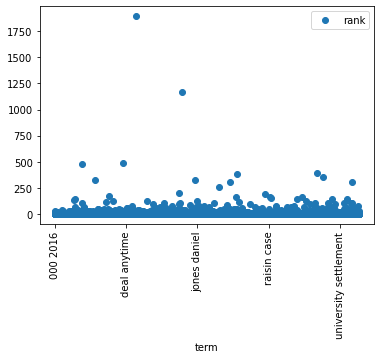

In [55]:
ranking.plot(x="term", y="rank", style="o", rot=90)

In [48]:
trigram = ranking["term"]
rank = ranking["rank"]

In [ ]:
fig = go.Figure(data=go.Scattergl(
    x = ,
    y = np.random.randn(N),
    mode='markers',
    marker=dict(
        color=np.random.randn(N),
        colorscale='Viridis',
        line_width=1
    )
))

fig.show()

#### **Bigram TF-IDF Logistic Regression**

In [ ]:
%%time

bigram_tfidf_logistic_regression = make_pipeline(
    CountVectorizer(
        stop_words='english',
        ngram_range=(1,2)
    ),
    TfidfTransformer(),
    LogisticRegression()
)

bigram_tfidf_logistic_regression.fit(X_train, y_train)

print(f'Accuracy: {bigram_tfidf_logistic_regression.score(X_test, y_test)} \n')
print(classification_report(y_test, bigram_tfidf_logistic_regression.predict(X_test)))

## Extra: word_count prediction based on news_desk and section_name, distinguish by type_of_material